# Part a: Gaussian Generative Model


## Import libraries


In [ ]:
import sklearn
from sklearn.preprocessing import StandardScaler
import numpy as np
from numpy.linalg import slogdet, inv
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd

## Data preprocessing


In [ ]:
digits = sklearn.datasets.load_digits()
## load the digits dataset from sklearn
X = digits.data
y = digits.target

## Create a 70% / 15% / 15% split:
X_train, X_temp, y_train, y_temp = sklearn.model_selection.train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = sklearn.model_selection.train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

##  standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

### 1. compute class priors pi_k


In [ ]:
# pi_k = P(y=k)
K = 10
N = X_train.shape[0]
pi = np.zeros(K)
for k in range(K):
    pi[k] = np.sum(y_train == k) / N

print("Class priors:", pi)

Class priors: [0.09864757 0.10103421 0.09864757 0.10182975 0.10103421 0.10103421
 0.10103421 0.09944312 0.09705648 0.10023866]


### 2. compute class means mu_k


In [ ]:
# mu_k = E[x|y=k]
D = X_train.shape[1]
mu = np.zeros((K, D))
for k in range(K):
    mu[k] = np.mean(X_train[y_train == k], axis=0)  # x given y=k

print("Class means shape:", mu.shape)

Class means shape: (10, 64)


### 3. compute shared covariance Σ


In [ ]:
# sigma= 1/n * sum_i (x_i - mu_(y_i))(x_i - mu_(y_i))^T
sigma = np.zeros((D, D))
for i in range(N):
    diff = (X_train[i] - mu[y_train[i]])[:, None]  # make it a column vector (D x 1)
    sigma += diff.dot(diff.T)
sigma /= N
print(
    "Shared covariance shape:", sigma.shape, " trace:", np.trace(sigma)
)  # trace is sum of diagonal elements

Shared covariance shape: (64, 64)  trace: 41.085022049776384


### 4. regularise Σ


In [9]:
# Σ_λ= Σ + λI
lambda_reg = 1e-3
sigma_reg = sigma + lambda_reg * np.eye(D)
print("Regularized covariance shape:", sigma_reg.shape, " trace:", np.trace(sigma_reg))

Regularized covariance shape: (64, 64)  trace: 41.14902204977638


### 5. computing log Gaussian scores


In [ ]:
# we assume p(x|y=k) ~ N(x;mu_k, Σ_λ) and p(y=k) = pi_k
# What we calculate is posterior score of sample x for class k = log p(y=k) + log p(x|y=k) <------- important
# log p(x|y=k) = -0.5 * [ D log(2pi) + log|Σ_λ| + (x - mu_k)^T Σ_λ^-1 (x - mu_k) ] from the multivariate normal distribution
# the term -0.5 * D log(2pi)- 0.5 * log|Σ_λ| is constant for all classes, so we can ignore it in the score computation


def compute_scores(X):
    N = X.shape[0]
    D = X.shape[1]
    K = mu.shape[0]
    scores = np.zeros((N, K))
    sign, logdet = slogdet(sigma_reg)
    if sign <= 0:
        raise ValueError("Covariance matrix is not positive definite.")
    sigma_inv = inv(sigma_reg)
    const_term = -0.5 * (
        D * np.log(2 * np.pi) + logdet
    )  # constant term for all classes
    for k in range(K):
        diff = X - mu[k]
        for i in range(N):
            mahalanobis = diff[i].T.dot(sigma_inv).dot(diff[i])
            log_likelihood = const_term - 0.5 * mahalanobis
            scores[i, k] = np.log(pi[k]) + log_likelihood
    return scores


# for each sample in X, compute scores and predict the class with highest score

### Functions to predict and calculate accuracy


In [ ]:
def predict_from_scores(scores):
    return np.argmax(scores, axis=1)


def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

## Hyperparameter Tuning and Evaluation


In [ ]:
lambdas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
best_acc = -np.inf
best_lam = None
lambdas_table = []

for lambda_reg in lambdas:
    sigma_reg = sigma + lambda_reg * np.eye(D)
    scores_val = compute_scores(X_val)
    y_val_pred = predict_from_scores(scores_val)
    acc = accuracy(y_val, y_val_pred)
    if acc > best_acc:
        best_acc = acc
        best_lam = lambda_reg
    lambdas_table.append((lambda_reg, acc))

lambdas_df = pd.DataFrame(lambdas_table, columns=["Lambda", "Validation Accuracy"])
print(lambdas_df)
print("\nbest lambda:", best_lam, "val acc:", best_acc)

    Lambda  Validation Accuracy
0   0.0001             0.944444
1   0.0010             0.944444
2   0.0100             0.944444
3   0.1000             0.944444
4   1.0000             0.922222
5  10.0000             0.848148

best lambda: 0.0001 val acc: 0.9444444444444444


### Final Model


In [ ]:
# combine train and val sets for final evaluation
X_combined = np.vstack((X_train, X_val))
y_combined = np.hstack((y_train, y_val))
N_combined = X_combined.shape[0]
lambda_reg = best_lam
sigma_reg = sigma + lambda_reg * np.eye(D)
scores_final = compute_scores(X_combined)
y_final_pred = predict_from_scores(scores_final)
final_acc = accuracy(y_combined, y_final_pred)
print(
    f"\nFinal accuracy on combined train+val set with lambda={best_lam}: {final_acc*100:.2f}%"
)


Final accuracy on combined train+val set with lambda=0.0001: 96.46%


### Metrics


In [ ]:
print("Test accuracy evaluation: ", f"{final_acc*100:.2f}%")
print(
    "Macro averaged precision: ",
    f"{precision_score(y_combined, y_final_pred, average='macro')*100:.2f}%",
)
print(
    "Macro averaged recall: ",
    f"{recall_score(y_combined, y_final_pred, average='macro')*100:.2f}%",
)
print(
    "Macro averaged F1-score: ",
    f"{f1_score(y_combined, y_final_pred, average='macro')*100:.2f}%",
)
print("Confusion Matrix:\n", confusion_matrix(y_combined, y_final_pred))

Test accuracy evaluation:  96.46%
Macro averaged precision:  96.52%
Macro averaged recall:  96.46%
Macro averaged F1-score:  96.48%
Confusion Matrix:
 [[150   0   0   0   0   0   1   0   0   0]
 [  0 146   1   0   1   0   0   0   2   4]
 [  0   0 148   3   0   0   0   0   0   0]
 [  0   0   1 149   0   1   0   0   3   1]
 [  0   1   0   0 149   0   0   1   2   1]
 [  0   0   0   0   0 147   1   0   0   7]
 [  0   2   0   0   1   0 151   0   0   0]
 [  0   0   0   0   0   0   0 150   0   2]
 [  0   6   0   0   0   0   0   1 139   2]
 [  0   0   0   1   0   1   0   2   5 144]]


## Comments


In [ ]:
# short explanation of the Gaussian Generative Model , parameter estimation and regularization.
# Gaussian Generative Model:
# - We assume each class y=k has a prior probability π_k = p(y=k), estimated from the fraction of training samples in that class.
# - The class-conditional distribution p(x | y=k) is multivariate Gaussian: x | y=k ~ N(μ_k, Σ),
#   where μ_k is the mean vector for class k and Σ is a shared covariance matrix across all classes.
# Parameter estimation:
# - π_k: proportion of training samples in class k.
# - μ_k: average of all training samples belonging to class k.
# - Σ: accumulated outer product of deviations (x_i - μ_{y_i})(x_i - μ_{y_i})^T over all samples, divided by total number of samples.
# Regularization:
# - To ensure numerical stability and invertibility, we use Σ_λ = Σ + λI.
# - λ > 0 prevents singular matrices and smooths the covariance; larger λ produces more “spherical” distributions.

In [ ]:
# Discussion:
# The confusion matrix shows that certain digits are more frequently confused with each other,
# particularly visually similar ones. For example, digits 1 and 7, or 3 and 8, are commonly misclassified,
# while digits like 0, 4, and 6 are recognized very accurately. These confusions reflect the inherent similarity
# in pixel patterns for these digits.

# The choice of λ had a clear effect on performance. Small λ values can lead to overfitting, making the model
# sensitive to noise in the training set, while very large λ oversmooths the covariance and reduces separation
# between classes. Overall, the Gaussian generative model is fast, interpretable, and works well for distinct
# digits, but its assumption of a shared covariance limits its ability to capture class-specific feature correlations,
# and it struggles with overlapping or non-Gaussian patterns in the data.

# Part b: Naïve Bayes


## Import libraries


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

path = '/Volumes/ELHOSS SSD/ML/lab3/adult.csv'
df = pd.read_csv(path, skipinitialspace=True)
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


## Selecting features and target


In [2]:
categorical_features = [
    "workclass", "education", "marital.status", "occupation",
    "relationship", "race", "sex", "native.country"
]
target_column = "income"

# Check columns
for c in categorical_features + [target_column]:
    if c not in df.columns:
        raise ValueError(f"Column missing: {c}")

df_categorial = df[categorical_features + [target_column]].copy()


## removing empty and ? values 

In [3]:
for f in categorical_features:
    df_categorial[f] = df_categorial[f].fillna("Unkown").astype(str).str.strip()
    df_categorial[f] = df_categorial[f].replace("?", "Unkown")

## Creating the dictonary(encoding the values)

In [4]:
dictionary = {}
X = pd.DataFrame()
for f in categorical_features:
    s = pd.Categorical(df_categorial[f])
    mapping = {category: i for i, category in enumerate(s.categories)}
    dictionary[f] = mapping
    X[f] = s.codes.astype(int)

Y = df_categorial[target_column].map({"<=50K": 0, ">50K": 1})


## splitting the data 

In [5]:
X_temp, X_test, Y_temp, Y_test = train_test_split(
    X, Y, test_size=0.15, stratify=Y, random_state=42
)
val_ratio = 0.15 / 0.85
X_train, X_val, Y_train, Y_val = train_test_split(
    X_temp, Y_temp, test_size=val_ratio, stratify=Y_temp, random_state=42
)

## The naive bayes classifier  

In [6]:
class NaiveBayesCategorical:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_priors = {}
        self.likelihoods = {}
        self.classes = None

    def fit(self, X_df, Y_ser):
        self.classes = np.unique(Y_ser)
        n_samples, n_features = X_df.shape
        class_count = Y_ser.value_counts()
        n_classes = len(self.classes)

        # class priors
        self.class_priors = {
            c: (class_count.get(c, 0) + self.alpha) / (n_samples + self.alpha * n_classes)
            for c in self.classes
        }

        # likelihoods
        self.likelihoods = {}
        for f in X_df.columns:
            self.likelihoods[f] = {}
            for c in self.classes:
                X_c = X_df[Y_ser == c]
                value_counts = X_c[f].value_counts().to_dict()
                n_values = len(X_df[f].unique())
                self.likelihoods[f][c] = {
                    k: (value_counts.get(k, 0) + self.alpha) / (len(X_c) + self.alpha * n_values)
                    for k in X_df[f].unique()
                }

    def predict_proba(self, X_df):
        proba = []
        for _, row in X_df.iterrows():
            class_probs = {}
            for c in self.classes:
                prob = self.class_priors[c]
                for f in X_df.columns:
                    prob *= self.likelihoods[f][c].get(
                        row[f],
                        self.alpha / (self.alpha * len(self.likelihoods[f][c]) + 1)
                    )
                class_probs[c] = prob
            total = sum(class_probs.values())
            for k in class_probs:
                class_probs[k] /= total
            proba.append(class_probs)
        return proba

    def predict(self, X_df):
        proba = self.predict_proba(X_df)
        preds = [max(p, key=p.get) for p in proba]
        return np.array(preds)


## alpha tunning 

In [7]:
alpha_values = [0.1, 0.5, 1.0, 2.0, 5.0]
best_alpha = None
best_alpha_acc = -1
for a in alpha_values:
    nb_a = NaiveBayesCategorical(alpha=a)
    nb_a.fit(X_train, Y_train)
    y_val_pred = nb_a.predict(X_val)
    acc = (y_val_pred == Y_val.values).mean()
    print(f"Alpha={a} -> Validation Accuracy: {acc:.4f}")
    if acc > best_alpha_acc:
        best_alpha_acc = acc
        best_alpha = a

print(f"\nBest alpha selected: {best_alpha} (val_acc={best_alpha_acc:.4f})")


Alpha=0.1 -> Validation Accuracy: 0.7932
Alpha=0.5 -> Validation Accuracy: 0.7932
Alpha=1.0 -> Validation Accuracy: 0.7926
Alpha=2.0 -> Validation Accuracy: 0.7922
Alpha=5.0 -> Validation Accuracy: 0.7922

Best alpha selected: 0.1 (val_acc=0.7932)


## finding the best subset 

In [8]:
subsets = [
    ["education", "occupation"],
    ["workclass", "education", "marital.status"],
    ["workclass", "education", "occupation"],
    ["education", "marital.status", "relationship"],
    categorical_features  
]

best_acc = -1
best_subset = None
for subset in subsets:
    nb = NaiveBayesCategorical(alpha=best_alpha)
    nb.fit(X_train[subset], Y_train)
    preds = nb.predict(X_val[subset])
    acc = (preds == Y_val.values).mean()
    print(f"Subset={subset} -> val_acc={acc:.4f}")
    if acc > best_acc:
        best_acc = acc
        best_subset = subset

print(f"\nBest subset: {best_subset} (val_acc={best_acc:.4f})")

Subset=['education', 'occupation'] -> val_acc=0.7809
Subset=['workclass', 'education', 'marital.status'] -> val_acc=0.8225
Subset=['workclass', 'education', 'occupation'] -> val_acc=0.7772
Subset=['education', 'marital.status', 'relationship'] -> val_acc=0.7557
Subset=['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country'] -> val_acc=0.7932

Best subset: ['workclass', 'education', 'marital.status'] (val_acc=0.8225)


## correlation analysis 

                workclass  education  marital.status  occupation  \
workclass           1.000     -0.014           0.034       0.277   
education          -0.014      1.000          -0.037      -0.044   
marital.status      0.034     -0.037           1.000       0.052   
occupation          0.277     -0.044           0.052       1.000   
relationship        0.001     -0.019           0.183      -0.020   
race                0.021      0.024          -0.071      -0.012   
sex                 0.014     -0.018          -0.125       0.030   
native.country     -0.006      0.077          -0.019      -0.004   

                relationship   race    sex  native.country  
workclass              0.001  0.021  0.014          -0.006  
education             -0.019  0.024 -0.018           0.077  
marital.status         0.183 -0.071 -0.125          -0.019  
occupation            -0.020 -0.012  0.030          -0.004  
relationship           1.000 -0.112 -0.584          -0.016  
race                 

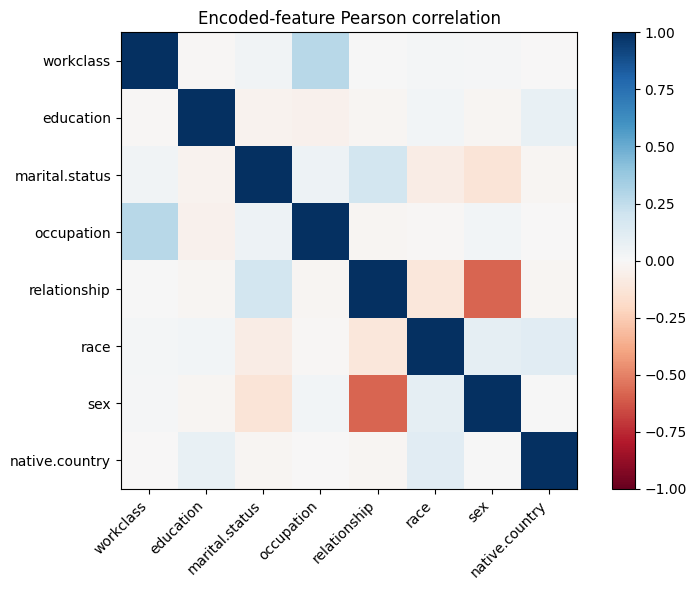

In [9]:
corr_matrix = X_train.corr()
print(corr_matrix.round(3))

plt.figure(figsize=(8,6))
plt.imshow(corr_matrix, cmap="RdBu", vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45, ha='right')
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title("Encoded-feature Pearson correlation")
plt.tight_layout()
plt.show()

In [10]:
features_to_remove = ["sex"]
kept_features = [f for f in best_subset if f not in features_to_remove]
print("Kept features:", kept_features)

Kept features: ['workclass', 'education', 'marital.status']


# Evaluation 

In [11]:
nb_final = NaiveBayesCategorical(alpha=best_alpha)
nb_final.fit(X_train[kept_features], Y_train)
pred_val_final = nb_final.predict(X_val[kept_features])
acc_final = (pred_val_final == Y_val.values).mean()
print(f"Validation accuracy: {acc_final:.4f}")

# Sklearn baseline
mnb = MultinomialNB(alpha=best_alpha)
mnb.fit(X_train[kept_features], Y_train)
acc_mnb = (mnb.predict(X_val[kept_features]) == Y_val.values).mean()
print(f"Sklearn MultinomialNB accuracy: {acc_mnb:.4f}")

Validation accuracy: 0.8225
Sklearn MultinomialNB accuracy: 0.7592


/Users/hossamelshazly/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/hossamelshazly/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/hossamelshazly/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


## best subset evaluation 

In [12]:
preds_test = nb_final.predict(X_test[kept_features])
test_acc = (preds_test == Y_test.values).mean()
print(f"Test accuracy: {test_acc:.4f}")
print(confusion_matrix(Y_test, preds_test))


Test accuracy: 0.8254
[[3466  243]
 [ 610  566]]


## Predicted Probability Analysis 

Min: 0.000, Max: 0.972, Mean: 0.239
Highly confident predictions: 2960 / 4884


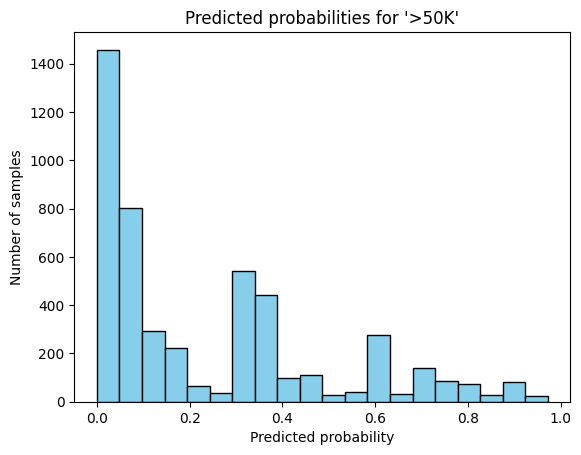

In [13]:
proba_val = nb_final.predict_proba(X_val[kept_features])
proba_class1 = np.array([p[1] for p in proba_val])

print(f"Min: {proba_class1.min():.3f}, Max: {proba_class1.max():.3f}, Mean: {proba_class1.mean():.3f}")
confident = ((proba_class1 > 0.8) | (proba_class1 < 0.2)).sum()
print(f"Highly confident predictions: {confident} / {len(proba_class1)}")

plt.hist(proba_class1, bins=20, color='skyblue', edgecolor='black')
plt.title("Predicted probabilities for '>50K'")
plt.xlabel("Predicted probability")
plt.ylabel("Number of samples")
plt.show()

## Naive Bayes assumes all features are conditionally independent given the class.
## Some features are correlated (like sex & relationship), which violates the assumption.
## This can bias probabilities (overconfident predictions), though accuracy often remains reasonable.